In [109]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

In [2]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days) + 1):
        yield start_date + timedelta(days=n)
team_name_mapping = {
    "Cleveland": "CLE",
    "Charlotte": "CHO",
    "LA Lakers": "LAL",
    "New Orleans": "NOP",
    "Brooklyn": "BRK",
    "Oklahoma City": "OKC",
    "Milwaukee": "MIL",
    "Phoenix": "PHO",
    "New York": "NYK",
    "Atlanta": "ATL",
    "Boston": "BOS",
    "Chicago": "CHI",
    "Dallas": "DAL",
    "Denver": "DEN",
    "Detroit": "DET",
    "Golden State": "GSW",
    "Houston": "HOU",
    "Indiana": "IND",
    "LA Clippers": "LAC",
    "Memphis": "MEM",
    "Miami": "MIA",
    "Minnesota": "MIN",
    "Orlando": "ORL",
    "Philadelphia": "PHI",
    "Portland": "POR",
    "Sacramento": "SAC",
    "San Antonio": "SAS",
    "Toronto": "TOR",
    "Utah": "UTA",
    "Washington": "WAS",
}

def rate_limit(requests, per_minute, last_request_time):
    if len(requests) >= per_minute:
        time_since_oldest_request = datetime.now() - requests[0]
        if time_since_oldest_request < timedelta(minutes=1):
            sleep_time = (timedelta(minutes=1) - time_since_oldest_request).total_seconds() + 1
            print(f"Rate limit reached, sleeping for {sleep_time} seconds.")
            time.sleep(sleep_time)
        requests.pop(0)  # Remove the oldest request
    requests.append(datetime.now())

request_times = []

def scrape_basic_box_score_stats(url, team_abbr):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:86.0) Gecko/20100101 Firefox/86.0'
    }
    response = requests.get(url, headers=headers)
    rate_limit(request_times, 9, datetime.now())
    if response.status_code != 200:
        print(f"Failed to retrieve data from {url}")
        return {}
    
    soup = BeautifulSoup(response.content, 'html.parser')
    table_id = f'box-{team_abbr}-game-basic'
    table = soup.find('table', id=table_id)

    desired_stats = {
        'FGA': None,
        'FG_pct': None,
        'FTA': None,
        'FT_pct': None,
        'TRB': None,
        'fg3a': None,
        'fg3_pct': None,
        'TOV': None,
        'stl': None,
        'blk': None,
        'ast': None
    }

    if table:
        totals_row = table.find('tfoot').find('tr')
        if totals_row:
            for stat in desired_stats.keys():
                data_cell = totals_row.find('td', {'data-stat': stat.lower()})
                if data_cell:
                    desired_stats[stat] = data_cell.text.strip()

    return desired_stats

def scrape_general_game_info(date):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.190 Safari/537.36'
    }
    url = f"https://www.basketball-reference.com/boxscores/?month={date.month:02d}&day={date.day:02d}&year={date.year}"
    rate_limit(request_times, 9, datetime.now())  
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Request failed for {url} with status code {response.status_code}")
        return []
    
    soup = BeautifulSoup(response.content, 'html.parser')
    games_info = []

    game_summaries = soup.find_all('div', class_='game_summary expanded nohover')
    for game_summary in game_summaries:
        teams = game_summary.find_all('tr', class_=['winner', 'loser'])
        box_score_link_tag = game_summary.find('p', class_='links').find('a', text='Box Score')
        if len(teams) == 2 and box_score_link_tag:
            box_score_link = "https://www.basketball-reference.com" + box_score_link_tag['href']
            team1, team1_score = teams[0].find('a').text.strip(), teams[0].find('td', class_='right').text.strip()
            team2, team2_score = teams[1].find('a').text.strip(), teams[1].find('td', class_='right').text.strip()
            game_info = {
                'date': date.strftime('%Y-%m-%d'),
                'team1': team1,
                'team1_score': team1_score,
                'team2': team2,
                'team2_score': team2_score,
                'box_score_link': box_score_link
            }
            # Scrape basic box score stats for both teams
            #time.sleep(random.uniform(3, 6))
            game_info['team1_stats'] = scrape_basic_box_score_stats(box_score_link, team_name_mapping[team1])
            game_info['team2_stats'] = scrape_basic_box_score_stats(box_score_link, team_name_mapping[team2])
            games_info.append(game_info)
    return games_info

In [4]:
# Define your date range
start_date = datetime(2023, 11, 1)
end_date = datetime(2024, 4, 5)
total_days = (end_date - start_date).days + 1

# Collect all games data
all_games_data = []
for single_date in tqdm(daterange(start_date, end_date), total=total_days, desc = "Scraping Data"):
    games_info = scrape_general_game_info(single_date)
    all_games_data.extend(games_info)

expanded_games_data = []

for game in all_games_data:
    # Extract basic game info
    game_info = {
        'date': game['date'],
        'team1': game['team1'],
        'team1_score': game['team1_score'],
        'team2': game['team2'],
        'team2_score': game['team2_score'],
    }

    # Extract team1 stats and prefix with 'team1_'
    team1_stats = {f'team1_{k}': v for k, v in game['team1_stats'].items()}
    game_info.update(team1_stats)

    # Extract team2 stats and prefix with 'team2_'
    team2_stats = {f'team2_{k}': v for k, v in game['team2_stats'].items()}
    game_info.update(team2_stats)

    # Add the expanded game info to the new list
    expanded_games_data.append(game_info)

# Convert to a DataFrame for analysis
df_games = pd.DataFrame(expanded_games_data)

# Display the dataset
print("Dataset with General Game Info and Basic Box Score Stats:")
print(df_games)

Scraping Data:   0%|          | 0/157 [00:00<?, ?it/s]C:\Users\Tyler\AppData\Local\Temp\ipykernel_28028\4122001294.py:104: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  box_score_link_tag = game_summary.find('p', class_='links').find('a', text='Box Score')


Rate limit reached, sleeping for 45.115537 seconds.
Rate limit reached, sleeping for 1.820209 seconds.
Rate limit reached, sleeping for 2.230715 seconds.
Rate limit reached, sleeping for 45.681781 seconds.
Rate limit reached, sleeping for 1.621998 seconds.
Rate limit reached, sleeping for 2.545918 seconds.


Scraping Data:   1%|          | 1/157 [02:17<5:57:54, 137.66s/it]

Rate limit reached, sleeping for 45.354366 seconds.
Rate limit reached, sleeping for 1.544028 seconds.
Rate limit reached, sleeping for 2.39054 seconds.


Scraping Data:   1%|▏         | 2/157 [03:18<3:59:10, 92.58s/it] 

Rate limit reached, sleeping for 45.330553 seconds.
Rate limit reached, sleeping for 1.418322 seconds.
Rate limit reached, sleeping for 2.388483 seconds.
Rate limit reached, sleeping for 44.872705 seconds.
Rate limit reached, sleeping for 1.4875880000000001 seconds.
Rate limit reached, sleeping for 2.047047 seconds.


Scraping Data:   2%|▏         | 3/157 [05:16<4:26:56, 104.00s/it]

Rate limit reached, sleeping for 45.434775 seconds.
Rate limit reached, sleeping for 1.845008 seconds.
Rate limit reached, sleeping for 1.516051 seconds.
Rate limit reached, sleeping for 44.37077 seconds.
Rate limit reached, sleeping for 1.78752 seconds.
Rate limit reached, sleeping for 2.746494 seconds.


Scraping Data:   3%|▎         | 4/157 [07:16<4:42:01, 110.60s/it]

Rate limit reached, sleeping for 1.299601 seconds.
Rate limit reached, sleeping for 45.182166 seconds.
Rate limit reached, sleeping for 1.484597 seconds.
Rate limit reached, sleeping for 2.2334259999999997 seconds.


Scraping Data:   3%|▎         | 5/157 [08:21<3:57:52, 93.90s/it] 

Rate limit reached, sleeping for 43.734088 seconds.
Rate limit reached, sleeping for 1.3280020000000001 seconds.
Rate limit reached, sleeping for 1.5371190000000001 seconds.
Rate limit reached, sleeping for 1.136378 seconds.
Rate limit reached, sleeping for 42.900545 seconds.
Rate limit reached, sleeping for 1.244959 seconds.
Rate limit reached, sleeping for 2.4811579999999998 seconds.
Rate limit reached, sleeping for 1.764844 seconds.
Rate limit reached, sleeping for 43.427948 seconds.
Rate limit reached, sleeping for 1.832678 seconds.
Rate limit reached, sleeping for 2.167516 seconds.


Scraping Data:   4%|▍         | 7/157 [11:21<3:27:45, 83.10s/it] 

Rate limit reached, sleeping for 1.102369 seconds.
Rate limit reached, sleeping for 1.424733 seconds.
Rate limit reached, sleeping for 43.578809 seconds.
Rate limit reached, sleeping for 1.492961 seconds.
Rate limit reached, sleeping for 1.871183 seconds.
Rate limit reached, sleeping for 1.546082 seconds.
Rate limit reached, sleeping for 43.712667 seconds.
Rate limit reached, sleeping for 1.791944 seconds.
Rate limit reached, sleeping for 2.312537 seconds.
Rate limit reached, sleeping for 43.98788 seconds.
Rate limit reached, sleeping for 1.6023939999999999 seconds.
Rate limit reached, sleeping for 2.396395 seconds.


Scraping Data:   5%|▌         | 8/157 [14:28<4:48:01, 115.98s/it]

Rate limit reached, sleeping for 1.141902 seconds.
Rate limit reached, sleeping for 44.081771 seconds.
Rate limit reached, sleeping for 2.098243 seconds.


Scraping Data:   6%|▌         | 9/157 [15:21<3:57:35, 96.32s/it] 

Rate limit reached, sleeping for 3.104755 seconds.
Rate limit reached, sleeping for 1.2524359999999999 seconds.
Rate limit reached, sleeping for 44.543849 seconds.
Rate limit reached, sleeping for 2.00246 seconds.
Rate limit reached, sleeping for 2.5530559999999998 seconds.
Rate limit reached, sleeping for 1.619286 seconds.
Rate limit reached, sleeping for 44.705981 seconds.
Rate limit reached, sleeping for 1.795412 seconds.
Rate limit reached, sleeping for 2.090709 seconds.


Scraping Data:   6%|▋         | 10/157 [17:26<4:18:10, 105.38s/it]

Rate limit reached, sleeping for 1.470864 seconds.
Rate limit reached, sleeping for 44.651732 seconds.
Rate limit reached, sleeping for 1.703816 seconds.
Rate limit reached, sleeping for 2.482545 seconds.


Scraping Data:   7%|▋         | 11/157 [18:28<3:43:26, 91.82s/it] 

Rate limit reached, sleeping for 1.354417 seconds.
Rate limit reached, sleeping for 44.685739 seconds.
Rate limit reached, sleeping for 1.7639 seconds.
Rate limit reached, sleeping for 2.397864 seconds.
Rate limit reached, sleeping for 45.340553 seconds.
Rate limit reached, sleeping for 1.8467639999999999 seconds.
Rate limit reached, sleeping for 2.340585 seconds.
Rate limit reached, sleeping for 45.978456 seconds.


Scraping Data:   8%|▊         | 12/157 [21:21<4:42:05, 116.73s/it]

Rate limit reached, sleeping for 2.0551690000000002 seconds.
Rate limit reached, sleeping for 2.5382949999999997 seconds.
Rate limit reached, sleeping for 45.644195 seconds.


Scraping Data:   8%|▊         | 13/157 [22:22<3:59:40, 99.87s/it] 

Rate limit reached, sleeping for 2.027629 seconds.
Rate limit reached, sleeping for 2.132237 seconds.
Rate limit reached, sleeping for 45.22977 seconds.
Rate limit reached, sleeping for 2.075682 seconds.
Rate limit reached, sleeping for 1.952029 seconds.
Rate limit reached, sleeping for 45.06408 seconds.
Rate limit reached, sleeping for 2.066987 seconds.


Scraping Data:   9%|▉         | 14/157 [24:30<4:17:50, 108.18s/it]

Rate limit reached, sleeping for 3.296948 seconds.
Rate limit reached, sleeping for 44.35486 seconds.
Rate limit reached, sleeping for 2.067099 seconds.
Rate limit reached, sleeping for 2.798047 seconds.
Rate limit reached, sleeping for 44.435124 seconds.
Rate limit reached, sleeping for 1.816171 seconds.


Scraping Data:  10%|▉         | 15/157 [26:31<4:25:10, 112.05s/it]

Rate limit reached, sleeping for 3.032247 seconds.


Scraping Data:  10%|█         | 16/157 [26:40<3:10:23, 81.02s/it] 

Rate limit reached, sleeping for 1.056489 seconds.
Rate limit reached, sleeping for 44.369252 seconds.
Rate limit reached, sleeping for 1.9872459999999998 seconds.
Rate limit reached, sleeping for 2.6408180000000003 seconds.
Rate limit reached, sleeping for 45.531188 seconds.
Rate limit reached, sleeping for 2.0337810000000003 seconds.
Rate limit reached, sleeping for 2.5224159999999998 seconds.
Rate limit reached, sleeping for 45.855257 seconds.
Rate limit reached, sleeping for 2.0741709999999998 seconds.


Scraping Data:  11%|█         | 17/157 [29:35<4:15:10, 109.36s/it]

Rate limit reached, sleeping for 3.134577 seconds.
Rate limit reached, sleeping for 43.5494 seconds.
Rate limit reached, sleeping for 1.9983300000000002 seconds.
Rate limit reached, sleeping for 2.5416499999999997 seconds.
Rate limit reached, sleeping for 1.934933 seconds.


Scraping Data:  11%|█▏        | 18/157 [30:45<3:45:53, 97.50s/it] 

Rate limit reached, sleeping for 1.118253 seconds.
Rate limit reached, sleeping for 43.329778 seconds.
Rate limit reached, sleeping for 1.358216 seconds.
Rate limit reached, sleeping for 2.481569 seconds.
Rate limit reached, sleeping for 1.5270899999999998 seconds.
Rate limit reached, sleeping for 43.226969 seconds.
Rate limit reached, sleeping for 1.361774 seconds.
Rate limit reached, sleeping for 1.183052 seconds.


Scraping Data:  12%|█▏        | 19/157 [32:50<4:03:11, 105.73s/it]

Rate limit reached, sleeping for 43.062144 seconds.
Rate limit reached, sleeping for 1.773812 seconds.
Rate limit reached, sleeping for 1.148556 seconds.
Rate limit reached, sleeping for 1.292535 seconds.
Rate limit reached, sleeping for 42.168051 seconds.
Rate limit reached, sleeping for 2.106928 seconds.
Rate limit reached, sleeping for 1.981947 seconds.
Rate limit reached, sleeping for 1.439691 seconds.


Scraping Data:  13%|█▎        | 20/157 [34:49<4:10:55, 109.89s/it]

Rate limit reached, sleeping for 1.6675849999999999 seconds.
Rate limit reached, sleeping for 42.229805 seconds.
Rate limit reached, sleeping for 2.18473 seconds.
Rate limit reached, sleeping for 1.9672070000000001 seconds.
Rate limit reached, sleeping for 1.668223 seconds.
Rate limit reached, sleeping for 43.188831 seconds.


Scraping Data:  13%|█▎        | 21/157 [36:37<4:07:19, 109.12s/it]

Rate limit reached, sleeping for 2.6553880000000003 seconds.
Rate limit reached, sleeping for 1.796453 seconds.
Rate limit reached, sleeping for 1.6278869999999999 seconds.
Rate limit reached, sleeping for 43.397226 seconds.
Rate limit reached, sleeping for 2.310066 seconds.
Rate limit reached, sleeping for 1.790778 seconds.
Rate limit reached, sleeping for 1.589362 seconds.
Rate limit reached, sleeping for 43.523575 seconds.
Rate limit reached, sleeping for 2.4212249999999997 seconds.
Rate limit reached, sleeping for 2.5075760000000002 seconds.
Rate limit reached, sleeping for 1.5293510000000001 seconds.
Rate limit reached, sleeping for 44.394624 seconds.
Rate limit reached, sleeping for 2.021919 seconds.


Scraping Data:  15%|█▍        | 23/157 [39:45<3:27:53, 93.09s/it] 

Rate limit reached, sleeping for 3.194085 seconds.
Rate limit reached, sleeping for 1.464131 seconds.
Rate limit reached, sleeping for 44.420202 seconds.
Rate limit reached, sleeping for 2.152978 seconds.
Rate limit reached, sleeping for 1.252998 seconds.
Rate limit reached, sleeping for 1.620854 seconds.
Rate limit reached, sleeping for 44.188796 seconds.
Rate limit reached, sleeping for 2.113161 seconds.
Rate limit reached, sleeping for 1.6828910000000001 seconds.
Rate limit reached, sleeping for 1.541178 seconds.


Scraping Data:  15%|█▌        | 24/157 [41:55<3:50:43, 104.08s/it]

Rate limit reached, sleeping for 44.481378 seconds.
Rate limit reached, sleeping for 1.774458 seconds.
Rate limit reached, sleeping for 2.26246 seconds.
Rate limit reached, sleeping for 1.406923 seconds.
Rate limit reached, sleeping for 44.142562 seconds.
Rate limit reached, sleeping for 2.303534 seconds.


Scraping Data:  16%|█▌        | 25/157 [43:47<3:54:32, 106.61s/it]

Rate limit reached, sleeping for 1.8643619999999999 seconds.
Rate limit reached, sleeping for 1.605315 seconds.
Rate limit reached, sleeping for 44.241705 seconds.
Rate limit reached, sleeping for 2.0974839999999997 seconds.
Rate limit reached, sleeping for 1.549115 seconds.
Rate limit reached, sleeping for 1.578894 seconds.
Rate limit reached, sleeping for 43.67998 seconds.


Scraping Data:  17%|█▋        | 26/157 [45:46<4:00:26, 110.13s/it]

Rate limit reached, sleeping for 2.840155 seconds.
Rate limit reached, sleeping for 1.493174 seconds.
Rate limit reached, sleeping for 1.4777719999999999 seconds.
Rate limit reached, sleeping for 43.699826 seconds.
Rate limit reached, sleeping for 2.123869 seconds.


Scraping Data:  17%|█▋        | 27/157 [46:51<3:29:37, 96.75s/it] 

Rate limit reached, sleeping for 1.290661 seconds.
Rate limit reached, sleeping for 1.273774 seconds.
Rate limit reached, sleeping for 1.475183 seconds.
Rate limit reached, sleeping for 43.302593 seconds.
Rate limit reached, sleeping for 2.1170299999999997 seconds.
Rate limit reached, sleeping for 2.5230930000000003 seconds.
Rate limit reached, sleeping for 1.617188 seconds.
Rate limit reached, sleeping for 42.500693 seconds.
Rate limit reached, sleeping for 2.353513 seconds.


Scraping Data:  18%|█▊        | 28/157 [48:52<3:43:35, 104.00s/it]

Rate limit reached, sleeping for 2.39046 seconds.
Rate limit reached, sleeping for 1.523548 seconds.
Rate limit reached, sleeping for 41.306332 seconds.
Rate limit reached, sleeping for 2.188021 seconds.
Rate limit reached, sleeping for 1.479836 seconds.
Rate limit reached, sleeping for 2.450816 seconds.


Scraping Data:  18%|█▊        | 29/157 [50:04<3:21:30, 94.46s/it] 

Rate limit reached, sleeping for 1.741487 seconds.
Rate limit reached, sleeping for 42.585253 seconds.
Rate limit reached, sleeping for 2.292693 seconds.
Rate limit reached, sleeping for 1.479114 seconds.
Rate limit reached, sleeping for 2.185336 seconds.
Rate limit reached, sleeping for 1.5439880000000001 seconds.
Rate limit reached, sleeping for 42.839932 seconds.
Rate limit reached, sleeping for 2.163274 seconds.
Rate limit reached, sleeping for 1.670558 seconds.
Rate limit reached, sleeping for 2.5362720000000003 seconds.


Scraping Data:  19%|█▉        | 30/157 [52:08<3:38:16, 103.12s/it]

Rate limit reached, sleeping for 44.462784 seconds.
Rate limit reached, sleeping for 1.059973 seconds.
Rate limit reached, sleeping for 1.575547 seconds.
Rate limit reached, sleeping for 2.356466 seconds.
Rate limit reached, sleeping for 43.798855 seconds.
Rate limit reached, sleeping for 1.395182 seconds.
Rate limit reached, sleeping for 2.2961910000000003 seconds.


Scraping Data:  20%|█▉        | 31/157 [54:01<3:43:04, 106.23s/it]

Rate limit reached, sleeping for 2.7440379999999998 seconds.
Rate limit reached, sleeping for 44.290877 seconds.
Rate limit reached, sleeping for 1.304233 seconds.
Rate limit reached, sleeping for 2.131772 seconds.
Rate limit reached, sleeping for 2.286046 seconds.
Rate limit reached, sleeping for 43.980126 seconds.
Rate limit reached, sleeping for 2.289962 seconds.
Rate limit reached, sleeping for 44.24146 seconds.


Scraping Data:  20%|██        | 32/157 [56:58<4:25:33, 127.47s/it]

Rate limit reached, sleeping for 1.440066 seconds.


Scraping Data:  21%|██        | 33/157 [57:00<3:05:48, 89.90s/it] 

Rate limit reached, sleeping for 3.088184 seconds.
Rate limit reached, sleeping for 1.439807 seconds.


Scraping Data:  22%|██▏       | 34/157 [57:11<2:15:27, 66.08s/it]

Rate limit reached, sleeping for 44.881505 seconds.
Rate limit reached, sleeping for 3.233695 seconds.


Scraping Data:  22%|██▏       | 35/157 [58:05<2:07:14, 62.58s/it]

Rate limit reached, sleeping for 1.6892209999999999 seconds.
Rate limit reached, sleeping for 44.275182 seconds.
Rate limit reached, sleeping for 2.912445 seconds.
Rate limit reached, sleeping for 1.434383 seconds.
Rate limit reached, sleeping for 44.493737 seconds.
Rate limit reached, sleeping for 3.737541 seconds.
Rate limit reached, sleeping for 1.376007 seconds.


Scraping Data:  23%|██▎       | 36/157 [1:00:15<2:46:40, 82.65s/it]

Rate limit reached, sleeping for 45.436378 seconds.
Rate limit reached, sleeping for 3.576049 seconds.


Scraping Data:  24%|██▎       | 37/157 [1:01:10<2:28:39, 74.33s/it]

Rate limit reached, sleeping for 1.834588 seconds.
Rate limit reached, sleeping for 44.115671 seconds.
Rate limit reached, sleeping for 3.749047 seconds.
Rate limit reached, sleeping for 1.5014720000000001 seconds.
Rate limit reached, sleeping for 1.040655 seconds.
Rate limit reached, sleeping for 44.215133 seconds.
Rate limit reached, sleeping for 3.294401 seconds.
Rate limit reached, sleeping for 1.3351060000000001 seconds.
Rate limit reached, sleeping for 44.373695 seconds.
Rate limit reached, sleeping for 2.888442 seconds.


Scraping Data:  24%|██▍       | 38/157 [1:04:12<3:31:50, 106.81s/it]

Rate limit reached, sleeping for 2.247879 seconds.


Scraping Data:  25%|██▌       | 40/157 [1:04:19<1:45:09, 53.92s/it] 

Rate limit reached, sleeping for 44.851451 seconds.
Rate limit reached, sleeping for 2.697917 seconds.
Rate limit reached, sleeping for 1.446261 seconds.
Rate limit reached, sleeping for 1.449081 seconds.
Rate limit reached, sleeping for 43.213718 seconds.
Rate limit reached, sleeping for 3.539187 seconds.
Rate limit reached, sleeping for 1.358149 seconds.
Rate limit reached, sleeping for 1.103927 seconds.
Rate limit reached, sleeping for 43.438105 seconds.
Rate limit reached, sleeping for 3.094629 seconds.
Rate limit reached, sleeping for 1.9602279999999999 seconds.


Scraping Data:  26%|██▌       | 41/157 [1:07:24<2:59:55, 93.07s/it]

Rate limit reached, sleeping for 43.484496 seconds.
Rate limit reached, sleeping for 3.19238 seconds.
Rate limit reached, sleeping for 2.749236 seconds.
Rate limit reached, sleeping for 43.10671 seconds.


Scraping Data:  27%|██▋       | 42/157 [1:09:11<3:06:39, 97.39s/it]

Rate limit reached, sleeping for 2.702203 seconds.
Rate limit reached, sleeping for 2.835057 seconds.
Rate limit reached, sleeping for 42.594169 seconds.
Rate limit reached, sleeping for 3.833301 seconds.
Rate limit reached, sleeping for 3.244889 seconds.
Rate limit reached, sleeping for 42.715582 seconds.


Scraping Data:  27%|██▋       | 43/157 [1:11:13<3:19:00, 104.74s/it]

Rate limit reached, sleeping for 4.4430130000000005 seconds.
Rate limit reached, sleeping for 2.325234 seconds.
Rate limit reached, sleeping for 43.590044 seconds.
Rate limit reached, sleeping for 3.819165 seconds.
Rate limit reached, sleeping for 2.817214 seconds.


Scraping Data:  28%|██▊       | 44/157 [1:12:28<3:00:24, 95.79s/it] 

Rate limit reached, sleeping for 44.243382 seconds.
Rate limit reached, sleeping for 3.332401 seconds.
Rate limit reached, sleeping for 2.545332 seconds.
Rate limit reached, sleeping for 43.13479 seconds.
Rate limit reached, sleeping for 3.651535 seconds.
Rate limit reached, sleeping for 2.878072 seconds.


Scraping Data:  29%|██▊       | 45/157 [1:14:29<3:13:00, 103.39s/it]

Rate limit reached, sleeping for 42.674829 seconds.
Rate limit reached, sleeping for 2.6624879999999997 seconds.
Rate limit reached, sleeping for 3.235085 seconds.
Rate limit reached, sleeping for 43.57925 seconds.
Rate limit reached, sleeping for 3.097429 seconds.
Rate limit reached, sleeping for 3.236943 seconds.
Rate limit reached, sleeping for 43.552932 seconds.


Scraping Data:  29%|██▉       | 46/157 [1:17:18<3:47:44, 123.11s/it]

Rate limit reached, sleeping for 3.768446 seconds.
Rate limit reached, sleeping for 2.846553 seconds.
Rate limit reached, sleeping for 43.852993 seconds.
Rate limit reached, sleeping for 3.450439 seconds.


Scraping Data:  30%|██▉       | 47/157 [1:18:25<3:14:49, 106.27s/it]

Rate limit reached, sleeping for 2.960362 seconds.
Rate limit reached, sleeping for 42.705457 seconds.
Rate limit reached, sleeping for 3.549116 seconds.
Rate limit reached, sleeping for 2.74883 seconds.
Rate limit reached, sleeping for 43.41981 seconds.
Rate limit reached, sleeping for 2.3362179999999997 seconds.
Rate limit reached, sleeping for 2.9835979999999998 seconds.


Scraping Data:  31%|███       | 48/157 [1:20:37<3:26:56, 113.92s/it]

Rate limit reached, sleeping for 43.339519 seconds.
Rate limit reached, sleeping for 1.064166 seconds.
Rate limit reached, sleeping for 2.891285 seconds.


Scraping Data:  31%|███       | 49/157 [1:21:37<2:56:09, 97.87s/it] 

Rate limit reached, sleeping for 43.932171 seconds.
Rate limit reached, sleeping for 2.427149 seconds.
Rate limit reached, sleeping for 2.297334 seconds.
Rate limit reached, sleeping for 43.292534 seconds.
Rate limit reached, sleeping for 1.573311 seconds.
Rate limit reached, sleeping for 2.552078 seconds.
Rate limit reached, sleeping for 1.864841 seconds.
Rate limit reached, sleeping for 43.406845 seconds.
Rate limit reached, sleeping for 1.292027 seconds.


Scraping Data:  32%|███▏      | 50/157 [1:24:28<3:33:10, 119.54s/it]

Rate limit reached, sleeping for 3.160893 seconds.
Rate limit reached, sleeping for 2.890645 seconds.
Rate limit reached, sleeping for 42.942045 seconds.
Rate limit reached, sleeping for 1.3577759999999999 seconds.
Rate limit reached, sleeping for 2.639992 seconds.
Rate limit reached, sleeping for 3.328569 seconds.
Rate limit reached, sleeping for 43.823148 seconds.
Rate limit reached, sleeping for 1.118006 seconds.


Scraping Data:  32%|███▏      | 51/157 [1:26:29<3:32:02, 120.03s/it]

Rate limit reached, sleeping for 1.3777 seconds.
Rate limit reached, sleeping for 2.686001 seconds.
Rate limit reached, sleeping for 43.15674 seconds.
Rate limit reached, sleeping for 1.465182 seconds.
Rate limit reached, sleeping for 1.997252 seconds.


Scraping Data:  33%|███▎      | 52/157 [1:27:37<3:03:02, 104.59s/it]

Rate limit reached, sleeping for 3.071639 seconds.
Rate limit reached, sleeping for 41.798713 seconds.
Rate limit reached, sleeping for 1.397334 seconds.
Rate limit reached, sleeping for 2.259075 seconds.
Rate limit reached, sleeping for 2.101334 seconds.
Rate limit reached, sleeping for 1.556912 seconds.
Rate limit reached, sleeping for 41.681078 seconds.
Rate limit reached, sleeping for 1.120397 seconds.
Rate limit reached, sleeping for 2.289224 seconds.
Rate limit reached, sleeping for 2.609217 seconds.
Rate limit reached, sleeping for 1.558901 seconds.
Rate limit reached, sleeping for 41.465495 seconds.
Rate limit reached, sleeping for 1.166677 seconds.
Rate limit reached, sleeping for 2.224266 seconds.


Scraping Data:  34%|███▍      | 53/157 [1:30:41<3:42:19, 128.26s/it]

Rate limit reached, sleeping for 2.623644 seconds.


Scraping Data:  34%|███▍      | 54/157 [1:30:44<2:35:56, 90.84s/it] 

Rate limit reached, sleeping for 1.8952170000000002 seconds.
Rate limit reached, sleeping for 41.701994 seconds.
Rate limit reached, sleeping for 1.303784 seconds.
Rate limit reached, sleeping for 2.0395380000000003 seconds.
Rate limit reached, sleeping for 1.400437 seconds.


Scraping Data:  35%|███▌      | 55/157 [1:31:50<2:21:37, 83.31s/it]

Rate limit reached, sleeping for 41.417107 seconds.
Rate limit reached, sleeping for 1.270618 seconds.
Rate limit reached, sleeping for 1.467111 seconds.
Rate limit reached, sleeping for 1.076218 seconds.
Rate limit reached, sleeping for 2.0243349999999998 seconds.
Rate limit reached, sleeping for 1.445787 seconds.
Rate limit reached, sleeping for 41.642904 seconds.
Rate limit reached, sleeping for 1.3313679999999999 seconds.
Rate limit reached, sleeping for 1.149937 seconds.
Rate limit reached, sleeping for 2.9140680000000003 seconds.
Rate limit reached, sleeping for 1.135836 seconds.
Rate limit reached, sleeping for 40.802891 seconds.


Scraping Data:  36%|███▌      | 56/157 [1:34:34<3:01:01, 107.54s/it]

Rate limit reached, sleeping for 1.221541 seconds.
Rate limit reached, sleeping for 1.7452320000000001 seconds.
Rate limit reached, sleeping for 3.234244 seconds.
Rate limit reached, sleeping for 1.7835800000000002 seconds.
Rate limit reached, sleeping for 41.805613 seconds.
Rate limit reached, sleeping for 1.657316 seconds.
Rate limit reached, sleeping for 1.655325 seconds.


Scraping Data:  36%|███▋      | 57/157 [1:35:43<2:40:01, 96.02s/it] 

Rate limit reached, sleeping for 2.930499 seconds.
Rate limit reached, sleeping for 1.581898 seconds.
Rate limit reached, sleeping for 41.807157 seconds.
Rate limit reached, sleeping for 1.605333 seconds.
Rate limit reached, sleeping for 3.666601 seconds.
Rate limit reached, sleeping for 1.483719 seconds.
Rate limit reached, sleeping for 40.567968 seconds.
Rate limit reached, sleeping for 1.283905 seconds.
Rate limit reached, sleeping for 1.452789 seconds.


Scraping Data:  37%|███▋      | 58/157 [1:37:44<2:50:45, 103.49s/it]

Rate limit reached, sleeping for 3.585973 seconds.
Rate limit reached, sleeping for 1.526755 seconds.
Rate limit reached, sleeping for 41.815493 seconds.
Rate limit reached, sleeping for 1.147788 seconds.
Rate limit reached, sleeping for 1.95736 seconds.
Rate limit reached, sleeping for 3.370403 seconds.
Rate limit reached, sleeping for 1.701414 seconds.
Rate limit reached, sleeping for 42.068145 seconds.
Rate limit reached, sleeping for 1.217064 seconds.
Rate limit reached, sleeping for 1.939908 seconds.
Rate limit reached, sleeping for 2.7348809999999997 seconds.


Scraping Data:  38%|███▊      | 59/157 [1:39:53<3:01:28, 111.11s/it]

Rate limit reached, sleeping for 2.198741 seconds.
Rate limit reached, sleeping for 41.542683 seconds.
Rate limit reached, sleeping for 1.04278 seconds.
Rate limit reached, sleeping for 2.090771 seconds.
Rate limit reached, sleeping for 3.158852 seconds.
Rate limit reached, sleeping for 1.456056 seconds.
Rate limit reached, sleeping for 42.052015 seconds.
Rate limit reached, sleeping for 1.502597 seconds.


Scraping Data:  38%|███▊      | 60/157 [1:41:44<2:59:22, 110.95s/it]

Rate limit reached, sleeping for 4.003538 seconds.
Rate limit reached, sleeping for 1.089243 seconds.
Rate limit reached, sleeping for 41.688918 seconds.
Rate limit reached, sleeping for 1.365275 seconds.


Scraping Data:  39%|███▉      | 61/157 [1:42:51<2:36:26, 97.77s/it] 

Rate limit reached, sleeping for 4.877949 seconds.
Rate limit reached, sleeping for 1.222157 seconds.
Rate limit reached, sleeping for 41.347877 seconds.
Rate limit reached, sleeping for 1.213977 seconds.
Rate limit reached, sleeping for 4.328634 seconds.
Rate limit reached, sleeping for 1.631737 seconds.
Rate limit reached, sleeping for 41.678948 seconds.
Rate limit reached, sleeping for 1.115446 seconds.


Scraping Data:  39%|███▉      | 62/157 [1:44:50<2:45:00, 104.22s/it]

Rate limit reached, sleeping for 1.4702549999999999 seconds.
Rate limit reached, sleeping for 4.547525 seconds.
Rate limit reached, sleeping for 1.667548 seconds.
Rate limit reached, sleeping for 41.738534 seconds.
Rate limit reached, sleeping for 1.363512 seconds.
Rate limit reached, sleeping for 4.932519 seconds.
Rate limit reached, sleeping for 1.5273240000000001 seconds.


Scraping Data:  40%|████      | 63/157 [1:46:03<2:28:44, 94.94s/it] 

Rate limit reached, sleeping for 42.347458 seconds.
Rate limit reached, sleeping for 1.495496 seconds.
Rate limit reached, sleeping for 5.125898 seconds.
Rate limit reached, sleeping for 41.951383 seconds.
Rate limit reached, sleeping for 1.608663 seconds.
Rate limit reached, sleeping for 4.974125 seconds.
Rate limit reached, sleeping for 1.3050359999999999 seconds.
Rate limit reached, sleeping for 41.279624 seconds.
Rate limit reached, sleeping for 1.7805149999999998 seconds.
Rate limit reached, sleeping for 5.007614 seconds.


Scraping Data:  41%|████      | 64/157 [1:49:02<3:06:13, 120.14s/it]

Rate limit reached, sleeping for 1.8090199999999999 seconds.
Rate limit reached, sleeping for 41.194999 seconds.


Scraping Data:  41%|████▏     | 65/157 [1:49:52<2:31:47, 98.99s/it] 

Rate limit reached, sleeping for 4.975572 seconds.
Rate limit reached, sleeping for 1.282982 seconds.
Rate limit reached, sleeping for 42.034986 seconds.
Rate limit reached, sleeping for 6.286768 seconds.
Rate limit reached, sleeping for 1.062483 seconds.
Rate limit reached, sleeping for 42.059968 seconds.
Rate limit reached, sleeping for 5.268436 seconds.
Rate limit reached, sleeping for 1.054662 seconds.
Rate limit reached, sleeping for 42.042994 seconds.


Scraping Data:  42%|████▏     | 66/157 [1:52:58<3:09:41, 125.08s/it]

Rate limit reached, sleeping for 1.366885 seconds.
Rate limit reached, sleeping for 5.024447 seconds.
Rate limit reached, sleeping for 1.236435 seconds.
Rate limit reached, sleeping for 41.49822 seconds.


Scraping Data:  43%|████▎     | 67/157 [1:53:59<2:39:04, 106.05s/it]

Rate limit reached, sleeping for 4.727774 seconds.
Rate limit reached, sleeping for 1.07921 seconds.
Rate limit reached, sleeping for 41.847055 seconds.
Rate limit reached, sleeping for 3.236134 seconds.
Rate limit reached, sleeping for 1.002443 seconds.
Rate limit reached, sleeping for 42.135389 seconds.
Rate limit reached, sleeping for 1.147494 seconds.


Scraping Data:  43%|████▎     | 68/157 [1:56:04<2:45:22, 111.49s/it]

Rate limit reached, sleeping for 5.087691 seconds.
Rate limit reached, sleeping for 40.574071 seconds.
Rate limit reached, sleeping for 1.003511 seconds.
Rate limit reached, sleeping for 1.407835 seconds.
Rate limit reached, sleeping for 4.999394000000001 seconds.
Rate limit reached, sleeping for 2.841681 seconds.
Rate limit reached, sleeping for 40.245333 seconds.


Scraping Data:  44%|████▍     | 69/157 [1:57:57<2:44:31, 112.18s/it]

Rate limit reached, sleeping for 2.010933 seconds.
Rate limit reached, sleeping for 4.819163 seconds.
Rate limit reached, sleeping for 2.637993 seconds.
Rate limit reached, sleeping for 40.81766 seconds.


Scraping Data:  45%|████▍     | 70/157 [1:59:02<2:21:53, 97.86s/it] 

Rate limit reached, sleeping for 5.692808 seconds.
Rate limit reached, sleeping for 2.8753539999999997 seconds.
Rate limit reached, sleeping for 40.402764 seconds.
Rate limit reached, sleeping for 5.050559 seconds.
Rate limit reached, sleeping for 2.490075 seconds.
Rate limit reached, sleeping for 40.571862 seconds.
Rate limit reached, sleeping for 1.033281 seconds.


Scraping Data:  45%|████▌     | 71/157 [2:01:08<2:32:24, 106.34s/it]

Rate limit reached, sleeping for 5.764871 seconds.
Rate limit reached, sleeping for 1.011915 seconds.
Rate limit reached, sleeping for 40.898277 seconds.
Rate limit reached, sleeping for 6.167279 seconds.
Rate limit reached, sleeping for 2.7770840000000003 seconds.


Scraping Data:  46%|████▌     | 72/157 [2:02:19<2:15:47, 95.85s/it] 

Rate limit reached, sleeping for 40.981376 seconds.
Rate limit reached, sleeping for 6.415442 seconds.
Rate limit reached, sleeping for 2.4236459999999997 seconds.
Rate limit reached, sleeping for 40.380288 seconds.
Rate limit reached, sleeping for 5.53087 seconds.
Rate limit reached, sleeping for 2.626323 seconds.
Rate limit reached, sleeping for 40.317416 seconds.


Scraping Data:  46%|████▋     | 73/157 [2:05:05<2:43:42, 116.93s/it]

Rate limit reached, sleeping for 1.239208 seconds.
Rate limit reached, sleeping for 6.32816 seconds.
Rate limit reached, sleeping for 2.400896 seconds.
Rate limit reached, sleeping for 40.426767 seconds.
Rate limit reached, sleeping for 1.222291 seconds.
Rate limit reached, sleeping for 5.655243 seconds.
Rate limit reached, sleeping for 2.872007 seconds.
Rate limit reached, sleeping for 40.420296 seconds.


Scraping Data:  47%|████▋     | 74/157 [2:07:06<2:43:23, 118.12s/it]

Rate limit reached, sleeping for 1.2613050000000001 seconds.
Rate limit reached, sleeping for 6.179148 seconds.
Rate limit reached, sleeping for 2.826196 seconds.
Rate limit reached, sleeping for 39.981439 seconds.


Scraping Data:  48%|████▊     | 75/157 [2:08:10<2:18:55, 101.65s/it]

Rate limit reached, sleeping for 1.483448 seconds.
Rate limit reached, sleeping for 5.8692 seconds.
Rate limit reached, sleeping for 2.945062 seconds.
Rate limit reached, sleeping for 40.51634 seconds.
Rate limit reached, sleeping for 6.636088 seconds.
Rate limit reached, sleeping for 2.619047 seconds.
Rate limit reached, sleeping for 40.814068 seconds.
Rate limit reached, sleeping for 5.92548 seconds.
Rate limit reached, sleeping for 2.971835 seconds.


Scraping Data:  48%|████▊     | 76/157 [2:10:27<2:31:55, 112.54s/it]

Rate limit reached, sleeping for 40.86459 seconds.


Scraping Data:  49%|████▉     | 77/157 [2:11:17<2:04:41, 93.52s/it] 

Rate limit reached, sleeping for 7.126444 seconds.
Rate limit reached, sleeping for 2.484324 seconds.
Rate limit reached, sleeping for 40.673919 seconds.
Rate limit reached, sleeping for 6.646016 seconds.
Rate limit reached, sleeping for 2.9462200000000003 seconds.
Rate limit reached, sleeping for 40.703684 seconds.
Rate limit reached, sleeping for 5.872749 seconds.


Scraping Data:  50%|████▉     | 78/157 [2:13:27<2:17:30, 104.43s/it]

Rate limit reached, sleeping for 3.203985 seconds.
Rate limit reached, sleeping for 40.08052 seconds.
Rate limit reached, sleeping for 6.451252 seconds.
Rate limit reached, sleeping for 2.388161 seconds.


Scraping Data:  50%|█████     | 79/157 [2:14:33<2:00:49, 92.94s/it] 

Rate limit reached, sleeping for 41.18419 seconds.
Rate limit reached, sleeping for 4.8753519999999995 seconds.
Rate limit reached, sleeping for 2.702118 seconds.
Rate limit reached, sleeping for 40.44888 seconds.


Scraping Data:  51%|█████     | 80/157 [2:16:23<2:05:48, 98.03s/it]

Rate limit reached, sleeping for 6.245894 seconds.
Rate limit reached, sleeping for 2.372468 seconds.
Rate limit reached, sleeping for 40.110926 seconds.
Rate limit reached, sleeping for 5.82651 seconds.
Rate limit reached, sleeping for 2.607892 seconds.
Rate limit reached, sleeping for 40.479941 seconds.


Scraping Data:  52%|█████▏    | 81/157 [2:18:22<2:12:27, 104.57s/it]

Rate limit reached, sleeping for 1.04001 seconds.
Rate limit reached, sleeping for 5.461436 seconds.
Rate limit reached, sleeping for 2.674397 seconds.
Rate limit reached, sleeping for 40.386652 seconds.
Rate limit reached, sleeping for 7.062569 seconds.
Rate limit reached, sleeping for 2.335762 seconds.


Scraping Data:  52%|█████▏    | 82/157 [2:19:38<1:59:44, 95.79s/it] 

Rate limit reached, sleeping for 41.191576 seconds.
Rate limit reached, sleeping for 5.69956 seconds.
Rate limit reached, sleeping for 2.6712689999999997 seconds.
Rate limit reached, sleeping for 40.993263 seconds.
Rate limit reached, sleeping for 1.018741 seconds.
Rate limit reached, sleeping for 4.499391 seconds.
Rate limit reached, sleeping for 2.732588 seconds.


Scraping Data:  53%|█████▎    | 83/157 [2:21:38<2:07:20, 103.25s/it]

Rate limit reached, sleeping for 40.08131 seconds.
Rate limit reached, sleeping for 1.132916 seconds.
Rate limit reached, sleeping for 4.7619679999999995 seconds.
Rate limit reached, sleeping for 2.656987 seconds.
Rate limit reached, sleeping for 40.672735 seconds.


Scraping Data:  54%|█████▎    | 84/157 [2:23:23<2:05:59, 103.55s/it]

Rate limit reached, sleeping for 1.6542919999999999 seconds.
Rate limit reached, sleeping for 4.409476 seconds.
Rate limit reached, sleeping for 2.7832689999999998 seconds.
Rate limit reached, sleeping for 40.770445 seconds.
Rate limit reached, sleeping for 1.070965 seconds.
Rate limit reached, sleeping for 4.267835 seconds.
Rate limit reached, sleeping for 2.599404 seconds.


Scraping Data:  54%|█████▍    | 85/157 [2:24:43<1:55:48, 96.51s/it] 

Rate limit reached, sleeping for 41.255649 seconds.
Rate limit reached, sleeping for 1.21685 seconds.
Rate limit reached, sleeping for 4.693315 seconds.
Rate limit reached, sleeping for 2.5791500000000003 seconds.
Rate limit reached, sleeping for 40.818519 seconds.
Rate limit reached, sleeping for 1.6109 seconds.


Scraping Data:  55%|█████▍    | 86/157 [2:26:34<1:59:18, 100.82s/it]

Rate limit reached, sleeping for 5.332578 seconds.
Rate limit reached, sleeping for 2.378468 seconds.
Rate limit reached, sleeping for 40.296462 seconds.
Rate limit reached, sleeping for 1.687541 seconds.
Rate limit reached, sleeping for 4.090888 seconds.
Rate limit reached, sleeping for 2.8836310000000003 seconds.
Rate limit reached, sleeping for 40.745038 seconds.
Rate limit reached, sleeping for 1.685825 seconds.


Scraping Data:  55%|█████▌    | 87/157 [2:28:34<2:04:32, 106.75s/it]

Rate limit reached, sleeping for 1.072321 seconds.
Rate limit reached, sleeping for 3.198656 seconds.
Rate limit reached, sleeping for 2.988248 seconds.
Rate limit reached, sleeping for 40.535553 seconds.
Rate limit reached, sleeping for 1.848937 seconds.
Rate limit reached, sleeping for 5.130848 seconds.
Rate limit reached, sleeping for 2.6876889999999998 seconds.
Rate limit reached, sleeping for 40.881396 seconds.
Rate limit reached, sleeping for 2.0382860000000003 seconds.
Rate limit reached, sleeping for 5.046148 seconds.
Rate limit reached, sleeping for 2.9753879999999997 seconds.


Scraping Data:  56%|█████▌    | 88/157 [2:30:48<2:11:56, 114.74s/it]

Rate limit reached, sleeping for 39.578277 seconds.
Rate limit reached, sleeping for 1.77786 seconds.
Rate limit reached, sleeping for 5.015117 seconds.
Rate limit reached, sleeping for 2.794186 seconds.
Rate limit reached, sleeping for 40.520818 seconds.


Scraping Data:  57%|█████▋    | 89/157 [2:32:32<2:06:23, 111.53s/it]

Rate limit reached, sleeping for 1.203654 seconds.
Rate limit reached, sleeping for 4.95934 seconds.
Rate limit reached, sleeping for 2.9207479999999997 seconds.
Rate limit reached, sleeping for 40.625294 seconds.
Rate limit reached, sleeping for 1.6357110000000001 seconds.
Rate limit reached, sleeping for 4.9391680000000004 seconds.
Rate limit reached, sleeping for 2.8427230000000003 seconds.
Rate limit reached, sleeping for 39.039903 seconds.
Rate limit reached, sleeping for 5.339339 seconds.
Rate limit reached, sleeping for 3.003114 seconds.


Scraping Data:  57%|█████▋    | 90/157 [2:34:51<2:14:03, 120.05s/it]

Rate limit reached, sleeping for 2.29888 seconds.
Rate limit reached, sleeping for 37.416894 seconds.
Rate limit reached, sleeping for 1.06537 seconds.
Rate limit reached, sleeping for 5.693311 seconds.
Rate limit reached, sleeping for 3.025731 seconds.
Rate limit reached, sleeping for 1.717263 seconds.
Rate limit reached, sleeping for 39.315121 seconds.


Scraping Data:  58%|█████▊    | 91/157 [2:36:36<2:06:52, 115.34s/it]

Rate limit reached, sleeping for 5.432141 seconds.
Rate limit reached, sleeping for 2.9120790000000003 seconds.
Rate limit reached, sleeping for 1.4093879999999999 seconds.
Rate limit reached, sleeping for 39.107897 seconds.
Rate limit reached, sleeping for 5.415284 seconds.
Rate limit reached, sleeping for 2.583822 seconds.
Rate limit reached, sleeping for 1.682934 seconds.
Rate limit reached, sleeping for 38.756296 seconds.


Scraping Data:  59%|█████▊    | 92/157 [2:38:41<2:08:05, 118.24s/it]

Rate limit reached, sleeping for 2.106386 seconds.
Rate limit reached, sleeping for 3.697328 seconds.
Rate limit reached, sleeping for 2.68654 seconds.
Rate limit reached, sleeping for 1.697518 seconds.
Rate limit reached, sleeping for 38.842089 seconds.


Scraping Data:  59%|█████▉    | 93/157 [2:39:42<1:47:46, 101.03s/it]

Rate limit reached, sleeping for 2.232063 seconds.
Rate limit reached, sleeping for 1.3152650000000001 seconds.
Rate limit reached, sleeping for 3.657986 seconds.
Rate limit reached, sleeping for 2.748964 seconds.
Rate limit reached, sleeping for 1.718272 seconds.
Rate limit reached, sleeping for 38.966973 seconds.
Rate limit reached, sleeping for 2.361856 seconds.
Rate limit reached, sleeping for 3.971584 seconds.
Rate limit reached, sleeping for 2.561143 seconds.
Rate limit reached, sleeping for 1.5189599999999999 seconds.
Rate limit reached, sleeping for 39.134398 seconds.
Rate limit reached, sleeping for 2.715976 seconds.
Rate limit reached, sleeping for 4.317852 seconds.


Scraping Data:  60%|█████▉    | 94/157 [2:41:55<1:56:11, 110.66s/it]

Rate limit reached, sleeping for 3.126238 seconds.
Rate limit reached, sleeping for 1.428943 seconds.
Rate limit reached, sleeping for 39.159305 seconds.
Rate limit reached, sleeping for 2.383189 seconds.
Rate limit reached, sleeping for 4.304099 seconds.
Rate limit reached, sleeping for 2.7807589999999998 seconds.
Rate limit reached, sleeping for 1.432804 seconds.
Rate limit reached, sleeping for 38.846219 seconds.


Scraping Data:  61%|██████    | 95/157 [2:43:44<1:53:46, 110.11s/it]

Rate limit reached, sleeping for 1.022467 seconds.
Rate limit reached, sleeping for 2.248953 seconds.
Rate limit reached, sleeping for 4.162141999999999 seconds.
Rate limit reached, sleeping for 2.81783 seconds.
Rate limit reached, sleeping for 1.872198 seconds.
Rate limit reached, sleeping for 38.869196 seconds.
Rate limit reached, sleeping for 2.525198 seconds.
Rate limit reached, sleeping for 3.644929 seconds.
Rate limit reached, sleeping for 2.67367 seconds.
Rate limit reached, sleeping for 1.596603 seconds.
Rate limit reached, sleeping for 39.063669 seconds.


Scraping Data:  61%|██████    | 96/157 [2:45:47<1:56:03, 114.15s/it]

Rate limit reached, sleeping for 2.61532 seconds.
Rate limit reached, sleeping for 3.859233 seconds.
Rate limit reached, sleeping for 2.779143 seconds.
Rate limit reached, sleeping for 1.676246 seconds.
Rate limit reached, sleeping for 39.112227 seconds.
Rate limit reached, sleeping for 2.174493 seconds.
Rate limit reached, sleeping for 3.955791 seconds.


Scraping Data:  62%|██████▏   | 97/157 [2:47:00<1:41:39, 101.66s/it]

Rate limit reached, sleeping for 3.261036 seconds.
Rate limit reached, sleeping for 1.385571 seconds.
Rate limit reached, sleeping for 38.329698 seconds.
Rate limit reached, sleeping for 1.81826 seconds.
Rate limit reached, sleeping for 4.115041 seconds.
Rate limit reached, sleeping for 2.566739 seconds.
Rate limit reached, sleeping for 1.67679 seconds.
Rate limit reached, sleeping for 38.842322 seconds.


Scraping Data:  62%|██████▏   | 98/157 [2:48:51<1:42:53, 104.63s/it]

Rate limit reached, sleeping for 1.36258 seconds.
Rate limit reached, sleeping for 1.5614780000000001 seconds.
Rate limit reached, sleeping for 4.163549 seconds.
Rate limit reached, sleeping for 2.655969 seconds.
Rate limit reached, sleeping for 1.825061 seconds.
Rate limit reached, sleeping for 38.563931 seconds.
Rate limit reached, sleeping for 1.902783 seconds.
Rate limit reached, sleeping for 3.602046 seconds.
Rate limit reached, sleeping for 2.903635 seconds.
Rate limit reached, sleeping for 1.8076370000000002 seconds.
Rate limit reached, sleeping for 38.986665 seconds.


Scraping Data:  63%|██████▎   | 99/157 [2:50:50<1:45:08, 108.77s/it]

Rate limit reached, sleeping for 1.605004 seconds.
Rate limit reached, sleeping for 3.989331 seconds.
Rate limit reached, sleeping for 2.757806 seconds.
Rate limit reached, sleeping for 1.666735 seconds.
Rate limit reached, sleeping for 39.024201 seconds.
Rate limit reached, sleeping for 1.435539 seconds.
Rate limit reached, sleeping for 2.028237 seconds.
Rate limit reached, sleeping for 3.784901 seconds.
Rate limit reached, sleeping for 2.6864689999999998 seconds.
Rate limit reached, sleeping for 1.8560889999999999 seconds.
Rate limit reached, sleeping for 38.737277 seconds.


Scraping Data:  64%|██████▎   | 100/157 [2:52:53<1:47:31, 113.19s/it]

Rate limit reached, sleeping for 1.57709 seconds.
Rate limit reached, sleeping for 1.457152 seconds.
Rate limit reached, sleeping for 4.081708 seconds.
Rate limit reached, sleeping for 2.802243 seconds.
Rate limit reached, sleeping for 1.966019 seconds.
Rate limit reached, sleeping for 39.063276 seconds.
Rate limit reached, sleeping for 1.423492 seconds.
Rate limit reached, sleeping for 1.416327 seconds.


Scraping Data:  64%|██████▍   | 101/157 [2:54:02<1:33:04, 99.72s/it] 

Rate limit reached, sleeping for 4.59138 seconds.
Rate limit reached, sleeping for 2.4265429999999997 seconds.
Rate limit reached, sleeping for 1.910269 seconds.
Rate limit reached, sleeping for 38.721553 seconds.
Rate limit reached, sleeping for 1.160372 seconds.
Rate limit reached, sleeping for 1.87083 seconds.
Rate limit reached, sleeping for 3.925427 seconds.
Rate limit reached, sleeping for 3.022742 seconds.
Rate limit reached, sleeping for 1.729023 seconds.
Rate limit reached, sleeping for 39.299268 seconds.
Rate limit reached, sleeping for 1.10514 seconds.
Rate limit reached, sleeping for 1.758124 seconds.
Rate limit reached, sleeping for 4.033574 seconds.
Rate limit reached, sleeping for 2.867039 seconds.
Rate limit reached, sleeping for 1.870903 seconds.
Rate limit reached, sleeping for 38.938151 seconds.


Scraping Data:  65%|██████▍   | 102/157 [2:56:57<1:52:14, 122.44s/it]

Rate limit reached, sleeping for 1.875028 seconds.
Rate limit reached, sleeping for 1.392735 seconds.
Rate limit reached, sleeping for 4.085045 seconds.


Scraping Data:  66%|██████▌   | 103/157 [2:57:10<1:20:34, 89.52s/it] 

Rate limit reached, sleeping for 3.394522 seconds.
Rate limit reached, sleeping for 1.382376 seconds.
Rate limit reached, sleeping for 39.236176 seconds.
Rate limit reached, sleeping for 1.798815 seconds.
Rate limit reached, sleeping for 4.078887 seconds.
Rate limit reached, sleeping for 2.753362 seconds.
Rate limit reached, sleeping for 1.982104 seconds.
Rate limit reached, sleeping for 38.918173 seconds.
Rate limit reached, sleeping for 2.0230300000000003 seconds.
Rate limit reached, sleeping for 3.457996 seconds.
Rate limit reached, sleeping for 2.946637 seconds.
Rate limit reached, sleeping for 1.043536 seconds.
Rate limit reached, sleeping for 39.205813 seconds.


Scraping Data:  66%|██████▌   | 104/157 [2:59:59<1:40:11, 113.42s/it]

Rate limit reached, sleeping for 2.687211 seconds.
Rate limit reached, sleeping for 3.736614 seconds.
Rate limit reached, sleeping for 2.854939 seconds.
Rate limit reached, sleeping for 1.516319 seconds.
Rate limit reached, sleeping for 38.798109 seconds.


Scraping Data:  67%|██████▋   | 105/157 [3:01:05<1:26:01, 99.27s/it] 

Rate limit reached, sleeping for 2.903689 seconds.
Rate limit reached, sleeping for 3.4843 seconds.
Rate limit reached, sleeping for 2.7968260000000003 seconds.
Rate limit reached, sleeping for 1.451735 seconds.
Rate limit reached, sleeping for 39.198146 seconds.
Rate limit reached, sleeping for 2.981885 seconds.
Rate limit reached, sleeping for 3.647921 seconds.
Rate limit reached, sleeping for 2.504551 seconds.
Rate limit reached, sleeping for 1.6509559999999999 seconds.
Rate limit reached, sleeping for 38.888551 seconds.
Rate limit reached, sleeping for 3.391824 seconds.
Rate limit reached, sleeping for 3.820606 seconds.
Rate limit reached, sleeping for 2.502922 seconds.
Rate limit reached, sleeping for 1.665695 seconds.
Rate limit reached, sleeping for 39.009821 seconds.


Scraping Data:  68%|██████▊   | 106/157 [3:04:08<1:45:39, 124.31s/it]

Rate limit reached, sleeping for 3.184842 seconds.
Rate limit reached, sleeping for 3.86286 seconds.
Rate limit reached, sleeping for 2.750262 seconds.
Rate limit reached, sleeping for 1.377948 seconds.
Rate limit reached, sleeping for 39.158164 seconds.


Scraping Data:  68%|██████▊   | 107/157 [3:05:06<1:27:03, 104.48s/it]

Rate limit reached, sleeping for 1.186458 seconds.


Scraping Data:  69%|██████▉   | 109/157 [3:05:09<41:30, 51.89s/it]   

Rate limit reached, sleeping for 3.06969 seconds.


Scraping Data:  70%|███████   | 110/157 [3:05:14<29:34, 37.76s/it]

Rate limit reached, sleeping for 3.470082 seconds.


Scraping Data:  71%|███████   | 111/157 [3:05:18<21:16, 27.75s/it]

Rate limit reached, sleeping for 2.9775739999999997 seconds.


Scraping Data:  71%|███████▏  | 112/157 [3:05:22<15:24, 20.55s/it]

Rate limit reached, sleeping for 2.13514 seconds.


Scraping Data:  72%|███████▏  | 113/157 [3:05:25<11:13, 15.30s/it]

Rate limit reached, sleeping for 39.331287 seconds.
Rate limit reached, sleeping for 1.616903 seconds.
Rate limit reached, sleeping for 4.2221519999999995 seconds.
Rate limit reached, sleeping for 2.702285 seconds.
Rate limit reached, sleeping for 1.487295 seconds.
Rate limit reached, sleeping for 38.358969 seconds.
Rate limit reached, sleeping for 1.452067 seconds.
Rate limit reached, sleeping for 1.651535 seconds.
Rate limit reached, sleeping for 4.1199829999999995 seconds.
Rate limit reached, sleeping for 2.826654 seconds.
Rate limit reached, sleeping for 1.840997 seconds.
Rate limit reached, sleeping for 39.165853 seconds.
Rate limit reached, sleeping for 1.393164 seconds.
Rate limit reached, sleeping for 1.063644 seconds.
Rate limit reached, sleeping for 3.974597 seconds.


Scraping Data:  73%|███████▎  | 114/157 [3:08:21<45:31, 63.52s/it]

Rate limit reached, sleeping for 3.188428 seconds.
Rate limit reached, sleeping for 1.20497 seconds.
Rate limit reached, sleeping for 39.021738 seconds.
Rate limit reached, sleeping for 1.3840970000000001 seconds.
Rate limit reached, sleeping for 1.136013 seconds.
Rate limit reached, sleeping for 3.949399 seconds.
Rate limit reached, sleeping for 2.687048 seconds.
Rate limit reached, sleeping for 1.635616 seconds.
Rate limit reached, sleeping for 39.054908 seconds.
Rate limit reached, sleeping for 1.60589 seconds.
Rate limit reached, sleeping for 4.124506 seconds.
Rate limit reached, sleeping for 2.717028 seconds.
Rate limit reached, sleeping for 1.526969 seconds.
Rate limit reached, sleeping for 39.016493 seconds.


Scraping Data:  73%|███████▎  | 115/157 [3:11:10<1:06:38, 95.20s/it]

Rate limit reached, sleeping for 1.9051960000000001 seconds.
Rate limit reached, sleeping for 4.233209 seconds.
Rate limit reached, sleeping for 2.6392160000000002 seconds.


Scraping Data:  74%|███████▍  | 116/157 [3:11:28<49:10, 71.96s/it]  

Rate limit reached, sleeping for 2.2162550000000003 seconds.
Rate limit reached, sleeping for 37.888211 seconds.
Rate limit reached, sleeping for 1.440012 seconds.
Rate limit reached, sleeping for 4.696381000000001 seconds.
Rate limit reached, sleeping for 2.792343 seconds.
Rate limit reached, sleeping for 1.485102 seconds.
Rate limit reached, sleeping for 39.249746 seconds.
Rate limit reached, sleeping for 1.03145 seconds.
Rate limit reached, sleeping for 5.307427 seconds.
Rate limit reached, sleeping for 2.360049 seconds.
Rate limit reached, sleeping for 1.907943 seconds.
Rate limit reached, sleeping for 38.969472 seconds.
Rate limit reached, sleeping for 1.4127480000000001 seconds.


Scraping Data:  75%|███████▍  | 117/157 [3:14:18<1:07:41, 101.54s/it]

Rate limit reached, sleeping for 4.312624 seconds.
Rate limit reached, sleeping for 2.630706 seconds.
Rate limit reached, sleeping for 1.6303670000000001 seconds.
Rate limit reached, sleeping for 39.043519 seconds.
Rate limit reached, sleeping for 1.624196 seconds.


Scraping Data:  75%|███████▌  | 118/157 [3:15:19<57:55, 89.13s/it]   

Rate limit reached, sleeping for 1.387729 seconds.
Rate limit reached, sleeping for 4.1259440000000005 seconds.
Rate limit reached, sleeping for 2.854491 seconds.
Rate limit reached, sleeping for 1.6967729999999999 seconds.
Rate limit reached, sleeping for 38.647478 seconds.
Rate limit reached, sleeping for 1.394237 seconds.
Rate limit reached, sleeping for 4.994166 seconds.
Rate limit reached, sleeping for 2.826857 seconds.
Rate limit reached, sleeping for 1.685543 seconds.
Rate limit reached, sleeping for 39.168852 seconds.
Rate limit reached, sleeping for 1.130714 seconds.
Rate limit reached, sleeping for 5.331408 seconds.
Rate limit reached, sleeping for 2.59641 seconds.
Rate limit reached, sleeping for 1.770422 seconds.


Scraping Data:  76%|███████▌  | 119/157 [3:17:37<1:05:45, 103.83s/it]

Rate limit reached, sleeping for 39.714741 seconds.
Rate limit reached, sleeping for 5.225846 seconds.
Rate limit reached, sleeping for 2.5504119999999997 seconds.
Rate limit reached, sleeping for 1.921127 seconds.
Rate limit reached, sleeping for 39.168092 seconds.
Rate limit reached, sleeping for 1.417819 seconds.


Scraping Data:  76%|███████▋  | 120/157 [3:19:23<1:04:29, 104.58s/it]

Rate limit reached, sleeping for 4.732508 seconds.
Rate limit reached, sleeping for 2.591774 seconds.
Rate limit reached, sleeping for 1.943718 seconds.
Rate limit reached, sleeping for 39.131265 seconds.
Rate limit reached, sleeping for 5.011993 seconds.
Rate limit reached, sleeping for 1.550206 seconds.
Rate limit reached, sleeping for 1.406202 seconds.
Rate limit reached, sleeping for 39.356225 seconds.


Scraping Data:  77%|███████▋  | 121/157 [3:21:25<1:05:47, 109.66s/it]

Rate limit reached, sleeping for 4.126327 seconds.
Rate limit reached, sleeping for 2.8286230000000003 seconds.
Rate limit reached, sleeping for 1.7361 seconds.
Rate limit reached, sleeping for 38.859129 seconds.
Rate limit reached, sleeping for 1.821427 seconds.
Rate limit reached, sleeping for 4.530866 seconds.
Rate limit reached, sleeping for 2.683643 seconds.
Rate limit reached, sleeping for 1.597037 seconds.
Rate limit reached, sleeping for 39.189282 seconds.
Rate limit reached, sleeping for 2.1587750000000003 seconds.


Scraping Data:  78%|███████▊  | 122/157 [3:23:27<1:06:15, 113.58s/it]

Rate limit reached, sleeping for 5.642009 seconds.
Rate limit reached, sleeping for 2.716568 seconds.
Rate limit reached, sleeping for 1.397073 seconds.
Rate limit reached, sleeping for 39.10266 seconds.
Rate limit reached, sleeping for 2.0224390000000003 seconds.


Scraping Data:  78%|███████▊  | 123/157 [3:24:30<55:46, 98.42s/it]   

Rate limit reached, sleeping for 6.104935 seconds.
Rate limit reached, sleeping for 1.955824 seconds.
Rate limit reached, sleeping for 1.6535069999999998 seconds.
Rate limit reached, sleeping for 39.029148 seconds.
Rate limit reached, sleeping for 1.774729 seconds.
Rate limit reached, sleeping for 5.305295 seconds.
Rate limit reached, sleeping for 2.8579369999999997 seconds.
Rate limit reached, sleeping for 1.058351 seconds.
Rate limit reached, sleeping for 39.300506 seconds.
Rate limit reached, sleeping for 2.1078989999999997 seconds.


Scraping Data:  79%|███████▉  | 124/157 [3:26:32<57:55, 105.32s/it]

Rate limit reached, sleeping for 5.257268 seconds.
Rate limit reached, sleeping for 2.962692 seconds.
Rate limit reached, sleeping for 1.10406 seconds.
Rate limit reached, sleeping for 39.040682 seconds.
Rate limit reached, sleeping for 2.029932 seconds.
Rate limit reached, sleeping for 4.858223000000001 seconds.
Rate limit reached, sleeping for 2.8281799999999997 seconds.
Rate limit reached, sleeping for 1.739947 seconds.


Scraping Data:  80%|███████▉  | 125/157 [3:27:47<51:20, 96.27s/it] 

Rate limit reached, sleeping for 39.602923 seconds.
Rate limit reached, sleeping for 1.5647579999999999 seconds.
Rate limit reached, sleeping for 5.228685 seconds.
Rate limit reached, sleeping for 2.786518 seconds.
Rate limit reached, sleeping for 39.380218 seconds.
Rate limit reached, sleeping for 1.520111 seconds.
Rate limit reached, sleeping for 5.093052 seconds.
Rate limit reached, sleeping for 3.045681 seconds.
Rate limit reached, sleeping for 40.995477 seconds.


Scraping Data:  80%|████████  | 126/157 [3:30:29<1:00:00, 116.13s/it]

Rate limit reached, sleeping for 3.28172 seconds.
Rate limit reached, sleeping for 2.978145 seconds.
Rate limit reached, sleeping for 40.316142 seconds.
Rate limit reached, sleeping for 3.16828 seconds.
Rate limit reached, sleeping for 3.263259 seconds.
Rate limit reached, sleeping for 2.540536 seconds.


Scraping Data:  81%|████████  | 127/157 [3:31:50<52:45, 105.53s/it]  

Rate limit reached, sleeping for 40.377266 seconds.
Rate limit reached, sleeping for 1.933561 seconds.
Rate limit reached, sleeping for 2.6855089999999997 seconds.
Rate limit reached, sleeping for 2.748016 seconds.
Rate limit reached, sleeping for 40.638743 seconds.


Scraping Data:  82%|████████▏ | 128/157 [3:33:43<52:07, 107.83s/it]

Rate limit reached, sleeping for 2.1344279999999998 seconds.
Rate limit reached, sleeping for 1.9558680000000002 seconds.
Rate limit reached, sleeping for 40.428976 seconds.
Rate limit reached, sleeping for 1.110146 seconds.
Rate limit reached, sleeping for 1.8953250000000001 seconds.
Rate limit reached, sleeping for 1.473932 seconds.
Rate limit reached, sleeping for 1.913688 seconds.
Rate limit reached, sleeping for 2.481203 seconds.
Rate limit reached, sleeping for 40.302978 seconds.
Rate limit reached, sleeping for 2.911117 seconds.
Rate limit reached, sleeping for 1.15364 seconds.


Scraping Data:  82%|████████▏ | 129/157 [3:35:43<51:55, 111.27s/it]

Rate limit reached, sleeping for 1.077781 seconds.
Rate limit reached, sleeping for 2.35467 seconds.
Rate limit reached, sleeping for 1.715611 seconds.
Rate limit reached, sleeping for 40.767548 seconds.
Rate limit reached, sleeping for 2.680653 seconds.
Rate limit reached, sleeping for 1.184503 seconds.
Rate limit reached, sleeping for 3.213192 seconds.
Rate limit reached, sleeping for 2.511933 seconds.
Rate limit reached, sleeping for 40.136832 seconds.


Scraping Data:  83%|████████▎ | 130/157 [3:37:37<50:31, 112.28s/it]

Rate limit reached, sleeping for 3.449413 seconds.
Rate limit reached, sleeping for 4.134315 seconds.
Rate limit reached, sleeping for 2.7239139999999997 seconds.
Rate limit reached, sleeping for 40.920532 seconds.
Rate limit reached, sleeping for 2.948849 seconds.
Rate limit reached, sleeping for 4.2020599999999995 seconds.
Rate limit reached, sleeping for 2.8574539999999997 seconds.
Rate limit reached, sleeping for 41.04028 seconds.
Rate limit reached, sleeping for 2.6430819999999997 seconds.


Scraping Data:  83%|████████▎ | 131/157 [3:39:43<50:26, 116.41s/it]

Rate limit reached, sleeping for 4.307508 seconds.
Rate limit reached, sleeping for 2.78808 seconds.
Rate limit reached, sleeping for 40.820167 seconds.
Rate limit reached, sleeping for 2.754119 seconds.
Rate limit reached, sleeping for 4.1294260000000005 seconds.


Scraping Data:  84%|████████▍ | 132/157 [3:40:53<42:41, 102.47s/it]

Rate limit reached, sleeping for 3.180007 seconds.
Rate limit reached, sleeping for 39.515498 seconds.
Rate limit reached, sleeping for 2.2539119999999997 seconds.
Rate limit reached, sleeping for 3.207806 seconds.
Rate limit reached, sleeping for 2.618295 seconds.
Rate limit reached, sleeping for 1.352898 seconds.
Rate limit reached, sleeping for 39.359432 seconds.
Rate limit reached, sleeping for 2.825951 seconds.
Rate limit reached, sleeping for 1.091193 seconds.


Scraping Data:  85%|████████▍ | 133/157 [3:42:49<42:31, 106.33s/it]

Rate limit reached, sleeping for 3.362718 seconds.
Rate limit reached, sleeping for 2.59769 seconds.
Rate limit reached, sleeping for 1.396424 seconds.
Rate limit reached, sleeping for 39.300728 seconds.
Rate limit reached, sleeping for 2.3729709999999997 seconds.
Rate limit reached, sleeping for 1.1838359999999999 seconds.
Rate limit reached, sleeping for 2.815305 seconds.
Rate limit reached, sleeping for 2.8451820000000003 seconds.
Rate limit reached, sleeping for 1.062832 seconds.
Rate limit reached, sleeping for 39.609817 seconds.
Rate limit reached, sleeping for 2.7526479999999998 seconds.
Rate limit reached, sleeping for 1.206937 seconds.


Scraping Data:  85%|████████▌ | 134/157 [3:44:52<42:43, 111.46s/it]

Rate limit reached, sleeping for 1.4015659999999999 seconds.
Rate limit reached, sleeping for 2.853143 seconds.
Rate limit reached, sleeping for 40.614758 seconds.
Rate limit reached, sleeping for 2.298484 seconds.
Rate limit reached, sleeping for 1.3175569999999999 seconds.
Rate limit reached, sleeping for 2.7717169999999998 seconds.
Rate limit reached, sleeping for 2.680871 seconds.


Scraping Data:  86%|████████▌ | 135/157 [3:46:03<36:26, 99.40s/it] 

Rate limit reached, sleeping for 41.351735 seconds.
Rate limit reached, sleeping for 2.367715 seconds.
Rate limit reached, sleeping for 1.5273029999999999 seconds.
Rate limit reached, sleeping for 3.025619 seconds.
Rate limit reached, sleeping for 2.8479289999999997 seconds.
Rate limit reached, sleeping for 41.015259 seconds.
Rate limit reached, sleeping for 2.189286 seconds.


Scraping Data:  87%|████████▋ | 136/157 [3:47:53<35:49, 102.34s/it]

Rate limit reached, sleeping for 1.909412 seconds.
Rate limit reached, sleeping for 2.6596599999999997 seconds.
Rate limit reached, sleeping for 2.7306559999999998 seconds.
Rate limit reached, sleeping for 40.309345 seconds.
Rate limit reached, sleeping for 2.7537000000000003 seconds.
Rate limit reached, sleeping for 1.391133 seconds.
Rate limit reached, sleeping for 2.4213199999999997 seconds.
Rate limit reached, sleeping for 3.005536 seconds.
Rate limit reached, sleeping for 41.11457 seconds.
Rate limit reached, sleeping for 2.75624 seconds.


Scraping Data:  87%|████████▋ | 137/157 [3:49:56<36:12, 108.65s/it]

Rate limit reached, sleeping for 2.0481499999999997 seconds.
Rate limit reached, sleeping for 2.10988 seconds.
Rate limit reached, sleeping for 2.958549 seconds.
Rate limit reached, sleeping for 40.976944 seconds.
Rate limit reached, sleeping for 2.6857819999999997 seconds.
Rate limit reached, sleeping for 1.456167 seconds.
Rate limit reached, sleeping for 2.5390189999999997 seconds.
Rate limit reached, sleeping for 2.73361 seconds.
Rate limit reached, sleeping for 40.922739 seconds.


Scraping Data:  88%|████████▊ | 138/157 [3:51:51<35:02, 110.68s/it]

Rate limit reached, sleeping for 3.574556 seconds.
Rate limit reached, sleeping for 2.899145 seconds.
Rate limit reached, sleeping for 2.6939 seconds.
Rate limit reached, sleeping for 41.039654 seconds.
Rate limit reached, sleeping for 2.416882 seconds.
Rate limit reached, sleeping for 1.287514 seconds.
Rate limit reached, sleeping for 2.724417 seconds.
Rate limit reached, sleeping for 2.837812 seconds.
Rate limit reached, sleeping for 40.654583 seconds.


Scraping Data:  89%|████████▊ | 139/157 [3:53:52<34:08, 113.81s/it]

Rate limit reached, sleeping for 2.876261 seconds.
Rate limit reached, sleeping for 1.133372 seconds.
Rate limit reached, sleeping for 2.464054 seconds.
Rate limit reached, sleeping for 2.8725959999999997 seconds.
Rate limit reached, sleeping for 40.978515 seconds.
Rate limit reached, sleeping for 3.022854 seconds.


Scraping Data:  89%|████████▉ | 140/157 [3:54:59<28:12, 99.56s/it] 

Rate limit reached, sleeping for 1.7190189999999999 seconds.
Rate limit reached, sleeping for 1.931159 seconds.
Rate limit reached, sleeping for 2.913423 seconds.
Rate limit reached, sleeping for 40.699959 seconds.
Rate limit reached, sleeping for 2.999063 seconds.
Rate limit reached, sleeping for 1.1837469999999999 seconds.
Rate limit reached, sleeping for 2.827036 seconds.
Rate limit reached, sleeping for 39.772843 seconds.


Scraping Data:  90%|████████▉ | 141/157 [3:56:56<27:59, 104.98s/it]

Rate limit reached, sleeping for 3.553342 seconds.
Rate limit reached, sleeping for 1.823579 seconds.
Rate limit reached, sleeping for 40.826237 seconds.
Rate limit reached, sleeping for 2.689297 seconds.
Rate limit reached, sleeping for 4.267378 seconds.
Rate limit reached, sleeping for 2.524197 seconds.


Scraping Data:  90%|█████████ | 142/157 [3:58:14<24:12, 96.84s/it] 

Rate limit reached, sleeping for 40.9131 seconds.
Rate limit reached, sleeping for 2.850793 seconds.
Rate limit reached, sleeping for 4.273515 seconds.
Rate limit reached, sleeping for 2.93705 seconds.
Rate limit reached, sleeping for 40.487359 seconds.
Rate limit reached, sleeping for 3.002331 seconds.
Rate limit reached, sleeping for 4.041491000000001 seconds.


Scraping Data:  91%|█████████ | 143/157 [4:00:12<24:03, 103.12s/it]

Rate limit reached, sleeping for 3.639933 seconds.
Rate limit reached, sleeping for 39.680144 seconds.
Rate limit reached, sleeping for 3.152849 seconds.
Rate limit reached, sleeping for 4.1595189999999995 seconds.
Rate limit reached, sleeping for 2.913588 seconds.
Rate limit reached, sleeping for 1.209037 seconds.
Rate limit reached, sleeping for 39.37538 seconds.
Rate limit reached, sleeping for 3.060996 seconds.
Rate limit reached, sleeping for 4.4208929999999995 seconds.


Scraping Data:  92%|█████████▏| 144/157 [4:02:13<23:32, 108.62s/it]

Rate limit reached, sleeping for 2.427641 seconds.
Rate limit reached, sleeping for 1.397969 seconds.
Rate limit reached, sleeping for 39.747771 seconds.
Rate limit reached, sleeping for 2.154706 seconds.
Rate limit reached, sleeping for 4.339963 seconds.
Rate limit reached, sleeping for 1.810731 seconds.
Rate limit reached, sleeping for 1.076288 seconds.
Rate limit reached, sleeping for 39.669237 seconds.


Scraping Data:  92%|█████████▏| 145/157 [4:04:02<21:44, 108.70s/it]

Rate limit reached, sleeping for 2.669924 seconds.
Rate limit reached, sleeping for 4.367463 seconds.
Rate limit reached, sleeping for 2.48492 seconds.
Rate limit reached, sleeping for 40.345987 seconds.
Rate limit reached, sleeping for 2.5833120000000003 seconds.
Rate limit reached, sleeping for 4.0947189999999996 seconds.
Rate limit reached, sleeping for 2.355663 seconds.
Rate limit reached, sleeping for 40.605854 seconds.
Rate limit reached, sleeping for 2.324363 seconds.
Rate limit reached, sleeping for 4.196977 seconds.


Scraping Data:  93%|█████████▎| 146/157 [4:06:18<21:23, 116.66s/it]

Rate limit reached, sleeping for 2.51113 seconds.
Rate limit reached, sleeping for 39.747762 seconds.
Rate limit reached, sleeping for 2.479835 seconds.
Rate limit reached, sleeping for 3.902054 seconds.


Scraping Data:  94%|█████████▎| 147/157 [4:07:19<16:40, 100.06s/it]

Rate limit reached, sleeping for 2.075555 seconds.
Rate limit reached, sleeping for 40.629633 seconds.
Rate limit reached, sleeping for 2.053658 seconds.
Rate limit reached, sleeping for 4.215194 seconds.
Rate limit reached, sleeping for 2.595618 seconds.
Rate limit reached, sleeping for 40.675411 seconds.
Rate limit reached, sleeping for 2.306708 seconds.
Rate limit reached, sleeping for 3.967745 seconds.
Rate limit reached, sleeping for 2.463458 seconds.
Rate limit reached, sleeping for 40.410561 seconds.
Rate limit reached, sleeping for 2.7414389999999997 seconds.
Rate limit reached, sleeping for 4.418281 seconds.


Scraping Data:  94%|█████████▍| 148/157 [4:10:19<18:36, 124.08s/it]

Rate limit reached, sleeping for 3.071071 seconds.


Scraping Data:  95%|█████████▍| 149/157 [4:10:27<11:54, 89.30s/it] 

Rate limit reached, sleeping for 41.712613 seconds.
Rate limit reached, sleeping for 2.4867600000000003 seconds.
Rate limit reached, sleeping for 3.922062 seconds.
Rate limit reached, sleeping for 2.951123 seconds.
Rate limit reached, sleeping for 41.008348 seconds.
Rate limit reached, sleeping for 2.6832089999999997 seconds.
Rate limit reached, sleeping for 4.397247999999999 seconds.
Rate limit reached, sleeping for 2.320694 seconds.
Rate limit reached, sleeping for 41.025583 seconds.
Rate limit reached, sleeping for 1.928366 seconds.
Rate limit reached, sleeping for 4.157165 seconds.


Scraping Data:  96%|█████████▌| 150/157 [4:13:26<13:32, 116.01s/it]

Rate limit reached, sleeping for 3.208074 seconds.
Rate limit reached, sleeping for 40.398478 seconds.
Rate limit reached, sleeping for 2.144051 seconds.
Rate limit reached, sleeping for 4.17171 seconds.


Scraping Data:  96%|█████████▌| 151/157 [4:14:24<09:52, 98.75s/it] 

Rate limit reached, sleeping for 2.185574 seconds.
Rate limit reached, sleeping for 41.075398 seconds.
Rate limit reached, sleeping for 2.5897490000000003 seconds.
Rate limit reached, sleeping for 4.0751 seconds.
Rate limit reached, sleeping for 2.776903 seconds.
Rate limit reached, sleeping for 40.901468 seconds.
Rate limit reached, sleeping for 2.268339 seconds.
Rate limit reached, sleeping for 4.149902 seconds.
Rate limit reached, sleeping for 2.82756 seconds.


Scraping Data:  97%|█████████▋| 152/157 [4:16:32<08:58, 107.63s/it]

Rate limit reached, sleeping for 40.206143 seconds.
Rate limit reached, sleeping for 2.6615130000000002 seconds.
Rate limit reached, sleeping for 4.308612999999999 seconds.
Rate limit reached, sleeping for 1.568462 seconds.
Rate limit reached, sleeping for 41.066081 seconds.
Rate limit reached, sleeping for 2.459239 seconds.


Scraping Data:  97%|█████████▋| 153/157 [4:18:22<07:12, 108.13s/it]

Rate limit reached, sleeping for 4.853453 seconds.
Rate limit reached, sleeping for 1.598691 seconds.
Rate limit reached, sleeping for 40.888077 seconds.
Rate limit reached, sleeping for 2.981621 seconds.
Rate limit reached, sleeping for 4.2269950000000005 seconds.
Rate limit reached, sleeping for 2.3982419999999998 seconds.
Rate limit reached, sleeping for 40.678297 seconds.
Rate limit reached, sleeping for 2.951315 seconds.
Rate limit reached, sleeping for 4.1263380000000005 seconds.


Scraping Data:  98%|█████████▊| 154/157 [4:20:29<05:41, 113.96s/it]

Rate limit reached, sleeping for 2.446293 seconds.
Rate limit reached, sleeping for 40.190466 seconds.
Rate limit reached, sleeping for 3.078606 seconds.
Rate limit reached, sleeping for 4.2943750000000005 seconds.
Rate limit reached, sleeping for 2.476016 seconds.
Rate limit reached, sleeping for 40.829382 seconds.
Rate limit reached, sleeping for 2.895568 seconds.
Rate limit reached, sleeping for 4.085203 seconds.


Scraping Data:  99%|█████████▊| 155/157 [4:22:32<03:53, 116.66s/it]

Rate limit reached, sleeping for 2.847435 seconds.
Rate limit reached, sleeping for 40.758911 seconds.
Rate limit reached, sleeping for 2.925939 seconds.
Rate limit reached, sleeping for 4.278781 seconds.


Scraping Data:  99%|█████████▉| 156/157 [4:23:36<01:40, 100.93s/it]

Rate limit reached, sleeping for 2.403764 seconds.
Rate limit reached, sleeping for 40.484015 seconds.
Rate limit reached, sleeping for 3.078972 seconds.
Rate limit reached, sleeping for 4.27807 seconds.
Rate limit reached, sleeping for 2.011189 seconds.
Rate limit reached, sleeping for 40.805505 seconds.
Rate limit reached, sleeping for 2.838026 seconds.
Rate limit reached, sleeping for 4.277112 seconds.
Rate limit reached, sleeping for 2.939896 seconds.
Rate limit reached, sleeping for 41.058994 seconds.
Rate limit reached, sleeping for 2.814693 seconds.
Rate limit reached, sleeping for 3.91784 seconds.


Scraping Data: 100%|██████████| 157/157 [4:26:36<00:00, 101.89s/it]

Dataset with General Game Info and Basic Box Score Stats:
            date        team1 team1_score         team2 team2_score team1_FGA  \
0     2023-11-01   Washington         121       Atlanta         130       101   
1     2023-11-01      Indiana         104        Boston         155       101   
2     2023-11-01      Chicago         105        Dallas         114        89   
3     2023-11-01     Portland         110       Detroit         101        81   
4     2023-11-01   Sacramento         101  Golden State         102        88   
...          ...          ...         ...           ...         ...       ...   
1098  2024-04-05      Detroit          90       Memphis         108        79   
1099  2024-04-05      Toronto         117     Milwaukee         111        79   
1100  2024-04-05  San Antonio         111   New Orleans         109        83   
1101  2024-04-05    Minnesota          87       Phoenix          97        85   
1102  2024-04-05     Portland         108    Washin

In [4]:
df_games.to_csv('br.csv', index = False)

NameError: name 'df_games' is not defined

In [190]:
br_df = pd.read_csv('br.csv')

unique_teams = pd.unique(br_df[['team1', 'team2']].values.ravel('K'))

# Map each team to a unique integer
team_to_id = {team: i for i, team in enumerate(unique_teams)}
print(team_to_id)
br_df['Home_Team_ID'] = br_df['team2'].map(team_to_id) # home team is team 2
br_df['Away_Team_ID'] = br_df['team1'].map(team_to_id) # away team is team 1

#Add win column
br_df['HomeWin'] = (br_df['team2_score'] > br_df['team1_score']).astype(int) #astype coverts boolean to integer 0 and 1

br_df['date'] = pd.to_datetime(br_df['date'])
br_df['month'] = (br_df['date'].dt.month - 11) % 12


print(br_df)

{'Washington': 0, 'Indiana': 1, 'Chicago': 2, 'Portland': 3, 'Sacramento': 4, 'Charlotte': 5, 'LA Clippers': 6, 'Brooklyn': 7, 'Denver': 8, 'Cleveland': 9, 'New Orleans': 10, 'Milwaukee': 11, 'Memphis': 12, 'Detroit': 13, 'Toronto': 14, 'San Antonio': 15, 'Orlando': 16, 'Dallas': 17, 'New York': 18, 'Golden State': 19, 'Boston': 20, 'Utah': 21, 'Atlanta': 22, 'LA Lakers': 23, 'Phoenix': 24, 'Miami': 25, 'Philadelphia': 26, 'Oklahoma City': 27, 'Minnesota': 28, 'Houston': 29}
           date        team1  team1_score         team2  team2_score  \
0    2023-11-01   Washington          121       Atlanta          130   
1    2023-11-01      Indiana          104        Boston          155   
2    2023-11-01      Chicago          105        Dallas          114   
3    2023-11-01     Portland          110       Detroit          101   
4    2023-11-01   Sacramento          101  Golden State          102   
...         ...          ...          ...           ...          ...   
1098 2024-04-05 

In [193]:
home_team = torch.tensor(br_df['Home_Team_ID'], dtype=torch.long)
away_team = torch.tensor(br_df['Away_Team_ID'], dtype=torch.long)
num_classes = 30 
home_teams_ohe = F.one_hot(home_team, num_classes=num_classes)
away_teams_ohe = F.one_hot(away_team, num_classes=num_classes)
date_stuff = torch.tensor(br_df['month'], dtype=torch.long)

months_ohe = F.one_hot(date_stuff, num_classes = 6)

x_ohe_tensor = torch.cat((home_teams_ohe, away_teams_ohe), dim=1)

numeric_data = br_df.drop(['date', 'Home_Team_ID', 'Away_Team_ID', 'HomeWin', 'team1', 'team2'], axis = 1).values
scaler = StandardScaler()
x_norm = scaler.fit_transform(numeric_data)
x_norm_tensor = torch.tensor(x_norm, dtype=torch.float32)

X_almost = torch.cat((x_norm_tensor, x_ohe_tensor), dim=1)
X = torch.cat((X_almost, months_ohe), dim = 1)

print(X.shape)

y = torch.tensor(br_df['HomeWin'], dtype=torch.long)

torch.Size([1103, 91])


In [194]:
class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        if opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    def train(self, X_train, y_train, X_val, y_val, early_stop=True, draw_curve=True):
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=True):
            # enable train mode
            self.model.train()
            epoch_loss, epoch_acc = 0.0, 0.0
            for X_batch, y_batch in train_loader:
                batch_importance = y_batch.shape[0] / len(train_dataset)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
                batch_acc = torch.sum(torch.argmax(y_pred, axis=1) == y_batch) / y_batch.shape[0]
                epoch_acc += batch_acc.detach().cpu().item() * batch_importance
            train_loss_list.append(epoch_loss)
            train_acc_list.append(epoch_acc)
            val_loss, val_acc = self.evaluate(val_dataset)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
            print(f"Validation accuracy: {np.mean(val_acc_list)}+/-{np.std(val_acc_list)}")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        # enable evaluation mode
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = y_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                batch_acc = torch.sum(torch.argmax(y_pred, axis=1) == y_batch) / y_batch.shape[0]
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc
            
            

In [195]:
def KFoldCrossValidation(
    model_class, k, 
    X, y,
    opt_method='adam', learning_rate=1e-3, batch_size=128, epoch=50, l2=0
):
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2)
    test_dataset = TensorDataset(X_test, y_test)
    kf = KFold(n_splits = k, shuffle = True)
    train_acc_list, test_acc_list = [], []
    for i, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"Fold {i}:")
        
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = model_class()
        # initialize a Trainer object
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2)
        # call trainer.train() here
        res = trainer.train(X_train, y_train, X_val, y_val)
        train_acc_best = res['train_acc_list'][np.argmin(res['val_loss_list'])]
        test_loss, test_acc = trainer.evaluate(test_dataset)
        if i == 1:
            torch.save(model.state_dict(), f'model_weights_fold_1.pth')
        train_acc_list.append(train_acc_best)
        test_acc_list.append(test_acc)
        
        print(f"Training accuracy: {train_acc_best}")
        print(f"Test accuracy: {test_acc}")
    
    print("Final results:")
    print(f"Training accuracy: {np.mean(train_acc_list)}+/-{np.std(train_acc_list)}")
    print(f"Test accuracy: {np.mean(test_acc_list)}+/-{np.std(test_acc_list)}")

In [196]:
class WinPredictor(nn.Module):
    def __init__(self, ):
        super(WinPredictor, self).__init__()
        
        # The input dimension here accounts for both teams' embeddings plus the other features
        self.fc1 = nn.Linear(91, 128)
        
        self.fc2 = nn.Linear(128, 64)
        # Adjusting the output layer for binary classification (win/loss)
        self.output_layer = nn.Linear(64, 2) 

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Using softmax activation function
        win_prob = F.softmax(self.output_layer(x), dim = 1)
        
        return win_prob


Fold 0:


100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


Validation accuracy: 0.9711956521739131+/-0.005297170839570078
Training accuracy: 1.0
Test accuracy: 0.9773755656108596
Fold 1:


100%|██████████| 50/50 [00:06<00:00,  8.10it/s]


Validation accuracy: 0.972228260869565+/-0.011558212368567182
Training accuracy: 0.998639455782313
Test accuracy: 0.990950226244344
Fold 2:


100%|██████████| 50/50 [00:06<00:00,  7.36it/s]


Validation accuracy: 0.9527520436909284+/-0.011242679850942317
Training accuracy: 0.9999999999999996
Test accuracy: 0.9909502238170056
Final results:
Training accuracy: 0.9995464852607708+/-0.0006413666949536702
Test accuracy: 0.9864253385574031+/-0.006399155818699538


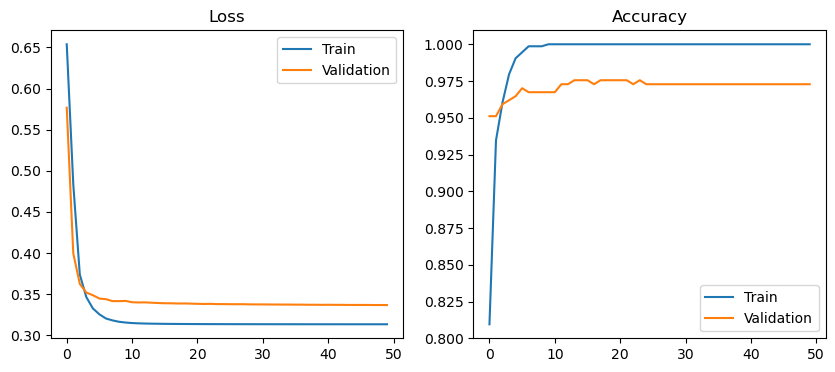

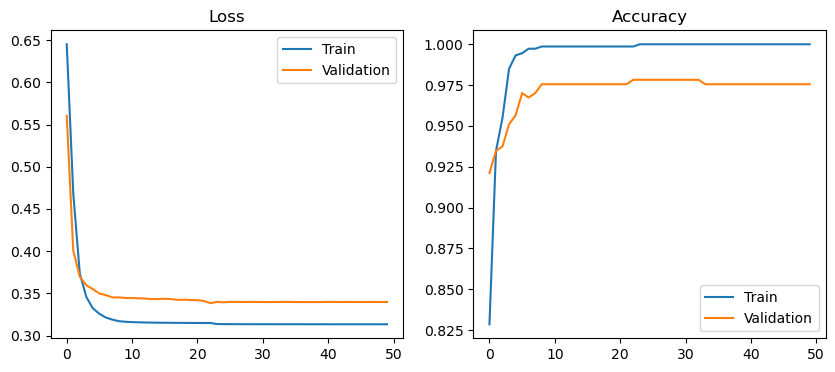

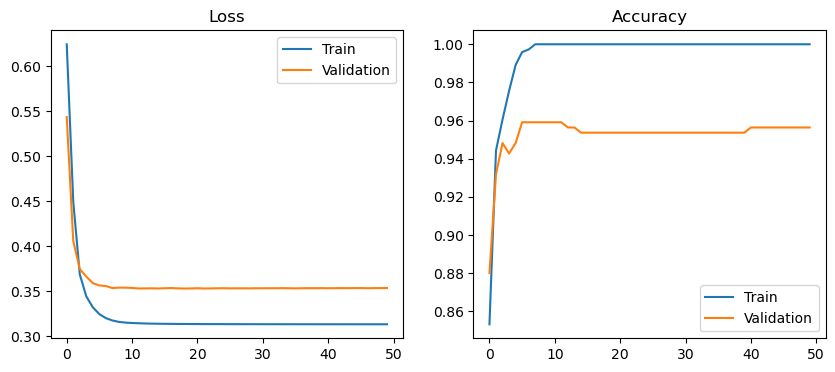

In [197]:
KFoldCrossValidation(WinPredictor, 3, X, y, batch_size = 32)

# {'Washington': 0, 'Indiana': 1, 'Chicago': 2, 'Portland': 3, 'Sacramento': 4, 'Charlotte': 5, 'LA Clippers': 6, 'Brooklyn': 7, 'Denver': 8, 'Cleveland': 9, 'New Orleans': 10, 'Milwaukee': 11, 'Memphis': 12, 'Detroit': 13, 'Toronto': 14, 'San Antonio': 15, 'Orlando': 16, 'Dallas': 17, 'New York': 18, 'Golden State': 19, 'Boston': 20, 'Utah': 21, 'Atlanta': 22, 'LA Lakers': 23, 'Phoenix': 24, 'Miami': 25, 'Philadelphia': 26, 'Oklahoma City': 27, 'Minnesota': 28, 'Houston': 29}

In [203]:
# Initialize your model
model = WinPredictor()
model.load_state_dict(torch.load('model_weights_fold_1.pth'))  # Load trained model weights
model.eval()  # Set the model to evaluation mode

# Assuming there are 30 teams
num_classes = 30

team_names = {
  0: 'Washington',
  1: 'Indiana',
  2: 'Chicago',
  3: 'Portland',
  4: 'Sacramento',
  5: 'Charlotte',
  6: 'LA Clippers',
  7: 'Brooklyn',
  8: 'Denver',
  9: 'Cleveland',
  10: 'New Orleans',
  11: 'Milwaukee',
  12: 'Memphis',
  13: 'Detroit',
  14: 'Toronto',
  15: 'San Antonio',
  16: 'Orlando',
  17: 'Dallas',
  18: 'New York',
  19: 'Golden State',
  20: 'Boston',
  21: 'Utah',
  22: 'Atlanta',
  23: 'LA Lakers',
  24: 'Phoenix',
  25: 'Miami',
  26: 'Philadelphia',
  27: 'Oklahoma City',
  28: 'Minnesota',
  29: 'Houston'
}


# Example games with just home and away team IDs
games = [{"home_team_id": 23, "away_team_id": 19},
        {"home_team_id": 23, "away_team_id": 19},
        {"home_team_id": 19, "away_team_id": 23},
        {"home_team_id": 19, "away_team_id": 23},
        {"home_team_id": 23, "away_team_id": 19},
        {"home_team_id": 19, "away_team_id": 23},
        {"home_team_id": 23, "away_team_id": 19}
       ]


home_team_ids = torch.tensor([game["home_team_id"] for game in games])
away_team_ids = torch.tensor([game["away_team_id"] for game in games])

home_teams_ohe = F.one_hot(home_team_ids, num_classes=num_classes).float()
away_teams_ohe = F.one_hot(away_team_ids, num_classes=num_classes).float()

input_batch = torch.cat((home_teams_ohe, away_teams_ohe), dim=1)

# Pad the input batch to match the expected input size of the model
padding_size = 91 - input_batch.size(1)
padded_input_batch = F.pad(input_batch, (0, padding_size), "constant", 0)

# Make predictions for the batch
with torch.no_grad():
    logits = model(padded_input_batch)  # Raw outputs from the model
    probabilities = F.softmax(logits, dim=1)  # Convert logits to probabilities

# Interpret the predictions and print probabilities
for i, (prob, predicted_class) in enumerate(zip(probabilities, predicted_classes)):
    home_team_name = team_names[games[i]["home_team_id"]]
    away_team_name = team_names[games[i]["away_team_id"]]
    print(f"Game {i + 1} between {home_team_name} and {away_team_name}:")
    print(f"Probability of {home_team_name} winning: {prob[0].item():.2f}")
    print(f"Probability of {away_team_name} winning: {prob[1].item():.2f}")
    if predicted_class.item() == 0:
        print(f"Predicted winner: {home_team_name}\n")
    else:
        print(f"Predicted winner: {away_team_name}\n")


Game 1 between LA Lakers and Golden State:
Probability of LA Lakers winning: 0.28
Probability of Golden State winning: 0.72
Predicted winner: Golden State

Game 2 between LA Lakers and Golden State:
Probability of LA Lakers winning: 0.28
Probability of Golden State winning: 0.72
Predicted winner: Golden State

Game 3 between Golden State and LA Lakers:
Probability of Golden State winning: 0.27
Probability of LA Lakers winning: 0.73
Predicted winner: LA Lakers

Game 4 between Golden State and LA Lakers:
Probability of Golden State winning: 0.27
Probability of LA Lakers winning: 0.73
Predicted winner: LA Lakers

Game 5 between LA Lakers and Golden State:
Probability of LA Lakers winning: 0.28
Probability of Golden State winning: 0.72
Predicted winner: Golden State

Game 6 between Golden State and LA Lakers:
Probability of Golden State winning: 0.27
Probability of LA Lakers winning: 0.73
Predicted winner: Golden State

Game 7 between LA Lakers and Golden State:
Probability of LA Lakers wi